In [1]:
%matplotlib inline

from collections import namedtuple
import numpy as np
from matplotlib import pyplot as plt
import time
import tt

from read_starcd import Mesh
#import read_starcd

In [13]:
#def rs_tt(f1, f2, vx_l, vx_r):
#    return vx_l * f1 + vx_r * f2
    
def F_m(vx, vy, vz, T, n, p):
    return n * ((1. / (2. * np.pi * p.Rg * T)) ** (3. / 2.)) * (np.exp(-(vx*vx + vy*vy + vz*vz) / (2. * p.Rg * T)))

def J_tt(f, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p):
    
    n = (hv ** 3) * tt.sum(f)

    ux = (1. / n) * (hv ** 3) * tt.sum(vx_tt * f)
    uy = (1. / n) * (hv ** 3) * tt.sum(vy_tt * f)
    uz = (1. / n) * (hv ** 3) * tt.sum(vz_tt * f)
    
    v2 = (vx_tt*vx_tt + vy_tt*vy_tt + vz_tt*vz_tt).round(r)
    u2 = ux*ux + uy*uy + uz*uz
    
    T = (1. / (3. * n * p.Rg)) * ((hv ** 3) * tt.sum(v2 * f) - n * u2)

    Vx = vx - ux
    Vy = vy - uy
    Vz = vz - uz
    
    Vx_tt = (vx_tt - ux * tt.ones((N,N,N))).round(r)
    Vy_tt = (vy_tt - uy * tt.ones((N,N,N))).round(r)
    Vz_tt = (vz_tt - uz * tt.ones((N,N,N))).round(r)

    rho = p.m * n

    P = rho * p.Rg * T

    cx = Vx_tt * (1. / ((2. * p.Rg * T) ** (1. / 2.)))
    cy = Vy_tt * (1. / ((2. * p.Rg * T) ** (1. / 2.)))   
    cz = Vz_tt * (1. / ((2. * p.Rg * T) ** (1. / 2.)))
    
    c2 = (cx*cx + cy*cy + cz*cz).round(r)

    Sx = (1. / n) * (hv ** 3) * tt.sum(cx * c2 * f)
    Sy = (1. / n) * (hv ** 3) * tt.sum(cy * c2 * f)
    Sz = (1. / n) * (hv ** 3) * tt.sum(cz * c2 * f)

    mu = p.mu_0 * ((p.T_0 + p.C) / (T + p.C)) * ((T / p.T_0) ** (3. / 2.))

    F_M = tt.tensor(F_m(Vx, Vy, Vz, T, n, p))
    
    f_plus = F_M * (tt.ones((N,N,N)) + (4. / 5.) * (1. - p.Pr) * (cx*Sx + cy*Sy + cz*Sz) * (c2 - (5. / 2.) * tt.ones((N,N,N))))
    f_plus = f_plus.round(r)
    
    J = (f_plus - f) * (P / mu)
    J = J.round(r)
    
    nu = P / mu
    
    return J, n, ux, T, nu

def solver_tt(mesh, vmax, N, Tau, CFL, n_l, u_l, T_l, r, p):
    
    # TODO add calculation of cell diameter
    h = np.min(mesh.cell_diam)
    tau = h * CFL / vmax
    
    t = 0.
    
    hv = 2. * vmax / N
    vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
    vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
    L = mesh.nc
    
#    v_nil = list(0. * tt.ones((N,N,N)) for i in range(mesh.nf))
    v_nil = []
    v_nil_max = np.zeros(mesh.nf)
#    v_nil_plus = list(0. * tt.ones((N,N,N)) for i in range(mesh.nf))
#    v_nil_minus = list(0. * tt.ones((N,N,N)) for i in range(mesh.nf))
    
    v_nil_tmp = np.zeros((N, N, N))
#    v_tmp_plus = np.zeros((N, N, N))
#    v_tmp_minus = np.zeros((N, N, N))
    
    for jf in range(mesh.nf):
        v_nil_tmp = mesh.face_normals[jf, 0] * vx + mesh.face_normals[jf, 1] * vy + mesh.face_normals[jf, 2] * vz
        v_nil_max[jf] = np.max(np.abs(v_nil_tmp))
        v_nil.append(tt.tensor(v_nil_tmp))
#        v_tmp = mesh.face_normals[jf, 0] * vx + mesh.face_normals[jf, 1] * vy + mesh.face_normals[jf, 2] * vz
#        v_nil[jf] = tt.tensor(v_tmp).round(r)
#        for i in np.ndindex(v_tmp.shape):
#            if v_tmp[i] > 0:
#                v_tmp_plus[i] = v_tmp[i]
#            else:
#                v_tmp_plus[i] = 0.
#        v_tmp_minus = v_tmp - v_tmp_plus
#        v_nil_plus[jf] = tt.tensor(v_tmp_plus).round(r)
#        v_nil_minus[jf] = tt.tensor(v_tmp_minus).round(r)
    
    vx_tt = tt.tensor(vx)
    vy_tt = tt.tensor(vy)
    vz_tt = tt.tensor(vz)
    
    M = u_l / ((p.g * p.Rg * T_l) ** .5)
    
    n_r = (p.g + 1.) * M * M / ((p.g - 1.) * M * M + 2.) * n_l
    u_r = ((p.g - 1.) * M * M + 2.) / ((p.g + 1.) * M * M) * u_l
    T_r = (2. * p.g * M * M - (p.g - 1.)) * ((p.g - 1.) * M * M + 2.) / ((p.g + 1) ** 2 * M * M) * T_l
    
    F_l = tt.tensor(F_m(vx-u_l, vy, vz, T_l, n_l, p))
    F_r = tt.tensor(F_m(vx-u_r, vy, vz, T_r, n_r, p))
    
    # initial condition 
    f = list(0. * tt.ones((N,N,N)) for i in range(L))
    
    
#    for i in range(L):
#        f[i, :, :, :] = problem.set_init_cond(mesh.cell_center_coo[i])
        
    for i in range(L):
        if (mesh.cell_center_coo[i, 0] < 0.):
            f[i] = F_l
        else:
            f[i] = F_r
    
    tmp = list(0. * tt.ones((N,N,N)) for i in range(L))
    # TODO: may be join f_plus and f_minus in one array
    f_plus = list(0. * tt.ones((N,N,N)) for i in range(mesh.nf))
    f_minus = list(0. * tt.ones((N,N,N)) for i in range(mesh.nf))
    Flow = list(0. * tt.ones((N,N,N)) for i in range(mesh.nf))
    RHS = list(0. * tt.ones((N,N,N)) for i in range(L))
    
    
    j = list(0. for i in range(L))
    jj = list(0. * tt.ones((N,N,N)) for i in range(L))
    
    Dens = np.zeros(L)
    Vel = np.zeros(L)
    Temp = np.zeros(L)
    
    Frob_norm_RHS = np.zeros(L)
    Frob_norm_iter = np.array([])
    
    t1 = time.clock()
    
    while(t < Tau*tau):
        t += tau
        # reconstruction for inner faces
        # 1st order
        for ic in range(L):
            for j in range(6):
                jf = mesh.cell_face_list[ic, j]
                # TODO: think how do this without 'if'
                if (mesh.cell_face_normal_direction[ic, j] == 1):
                    f_minus[jf] = f[ic]
                else:
                    f_plus[jf] = f[ic]
                
        # boundary condition
        # loop over all boundary faces
        for j in range(mesh.nbf):
            jf = mesh.bound_face_info[j, 0] # global face index
                # TODO: think how do this without 'if'
            if (mesh.bound_face_info[j, 1] == 2): # symmetry
                if (mesh.bound_face_info[j, 2] == 1):
                    f_plus[jf] = f_minus[jf]
                else:
                    f_minus[jf] = f_plus[jf]
            elif (mesh.bound_face_info[j, 1] == 0): # inlet
                if (mesh.bound_face_info[j, 2] == 1):
                    f_plus[jf] = F_l
                else:
                    f_minus[jf] = F_l
            elif (mesh.bound_face_info[j, 1] == 1): # outlet
                if (mesh.bound_face_info[j, 2] == 1):
                    f_plus[jf] = F_r
                else:
                    f_minus[jf] = F_r
                
        # compute slopes
        
#        for i in range(1, L-1):
#            slope[i, :, :, :] = h * (f[i+1, :, :, :] - 2 * f[i, :, :, :] + f[i-1, :, :, :])
#            slope[i, :, :, :] = h * minmod(f[i+1, :, :, :] - f[i, :, :, :], f[i, :, :, :] - f[i-1, :, :, :])
        
        # riemann solver - compute fluxes
        # цикл по граням 
        for jf in range(mesh.nf):
#            v_nil = mesh.face_normals[jf, 0] * vx + mesh.face_normals[jf, 1] * vy + mesh.face_normals[jf, 2] * vz
#            v_nil_max = np.max(np.abs(v_nil))
            Flow[jf] = (1. / 2.) * mesh.face_areas[jf] * (v_nil[jf] * (f_plus[jf] + f_minus[jf]) - v_nil_max[jf] * (f_plus[jf] - f_minus[jf]))
#            Flow[jf] = mesh.face_areas[jf] * (v_nil_plus[jf] * f_minus[jf] + v_nil_minus[jf] * f_plus[jf])
            Flow[jf] = Flow[jf].round(r)
        
#        RHS[:] = 0.
        for ic in range(L):
            RHS[ic] *= 0.
            for lf in range(6):
                jf = mesh.cell_face_list[ic, lf]
                RHS[ic] += - (mesh.cell_face_normal_direction[ic, lf]) * (1. / mesh.cell_volumes[ic]) * Flow[jf]
#            j[ic] = J_tt(f[ic], vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)
#            jj[ic] = j[ic][0]
#            jj[ic] = J_tt(f[ic], vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[0]
            RHS[ic] += J_tt(f[ic], vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[0]#jj[ic]
            RHS[ic] = RHS[ic].round(r)
        
            
        # compute RHS
  #      for ic in range(L):            
  #          RHS[ic, :, :, :] = (- Flow[ic, :, :, :]) / cell_volumes[ic] + J(f[ic, :, :, :], vx, vy, vz, hv, N, p)[0]
        Frob_norm_iter = np.append(Frob_norm_iter, sum([RHS[ic].norm() for ic in range(L)]))
#            C_norm = np.append(C_norm, np.max(np.absolute(np.ravel(RHS))))
            
#        nu = 

        # update values
        for ic in range(L):
            tmp[ic] = f[ic] + tau * RHS[ic]
            tmp[ic] = tmp[ic].round(r)
                
        f = tmp
        
#        print np.linalg.norm(RHS)
#        print np.max(np.absolute((j)))
        
     
        
    t2 = time.clock() - t1

    t2 = int(round(t2))
    
    print "time =", t2 / 3600, "h", (t2 % 3600) / 60, "m", t2 % 60, "s"

    for ic in range(L):
        Dens[ic] = J_tt(f[ic], vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[1]
        Vel[ic] = J_tt(f[ic], vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[2]
        Temp[ic] = J_tt(f[ic], vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[3]
        
    for ic in range(L):
        Frob_norm_RHS[ic] = RHS[ic].norm()

#    l = 1. / ((2 ** .5) * np.pi * n_l * p.d * p.d)
        
#    delta = l / (n_r - n_l) * np.max(Dens[1:] - Dens[:-1]) / (2 * h)
    
    Return = namedtuple('Return', ['f', 'Dens', 'Vel', 'Temp', 'Frob_norm_iter', 'Frob_norm_RHS'])#, 'delta', 'Frob_norm_iter', 'Frob_norm_RHS'])
    
    S = Return(f, Dens, Vel, Temp, Frob_norm_iter, Frob_norm_RHS)
    
    return S

In [18]:
class Params(object):
 
    def __init__(self):
        #fundamental constants
        self.Na = 6.02214129e+23
        self.kB = 1.381e-23 # J / K
        #gas parameters
        self.Mol = 40e-3 # kg / mol
        self.Rg = 8.3144598  / self.Mol  # J / (kg * K) 
        self.m = self.Mol / self.Na # kg
    
        self.Pr = 2. / 3.
        self.C = 144.4
        self.T_0 = 273.11
        self.mu_0 = 2.125e-05
    
        self.g = 5. / 3.
        
        self.d = 3418e-13

p = Params()

N = 30
vmax = 2000.

Tau = 100

n_l = 2e+23 
u_l = 400.
T_l = 300.

M = u_l / ((p.g * p.Rg * T_l) ** .5)

n_r = (p.g + 1.) * M * M / ((p.g - 1.) * M * M + 2.) * n_l
u_r = ((p.g - 1.) * M * M + 2.) / ((p.g + 1.) * M * M) * u_l
T_r = (2. * p.g * M * M - (p.g - 1.)) * ((p.g - 1.) * M * M + 2.) / ((p.g + 1) ** 2 * M * M) * T_l

l = 1. / ((2 ** .5) * np.pi * n_l * p.d * p.d)

CFL = 0.5

r = 1e-7


mesh = Mesh() 

path = './'
mesh.read_starcd(path, 3 * l)

L = mesh.nc

Number of boundary faces =  322
Number of boundary conditions =  3
Number of cells =  80
Number of vertices =  324
Number of faces =  401
sum of volumes: 3.202009741819246e-13


In [27]:
print 'Max =', M

print 'n_l =', n_l, 'n_r =', n_r
print 'u_l =', u_l, 'u_r =', u_r
print 'T_l =', T_l, 'T_r =', T_r

hv = 2. * vmax / N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')

M_l = F_m(vx-u_l, vy, vz, T_l, n_l, p)
M_r = F_m(vx-u_r, vy, vz, T_r, n_r, p)

M_l_tt = tt.tensor(M_l).round(r)
M_r_tt = tt.tensor(M_r).round(r)

vx_tt = tt.tensor(vx)
vy_tt = tt.tensor(vy)
vz_tt = tt.tensor(vz)

print 'Dens'
print (J_tt(M_l_tt, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[1] - n_l) / n_l
print (J_tt(M_r_tt, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[1] - n_r) / n_r

print 'Vel'
print (J_tt(M_l_tt, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[2] - u_l) / u_l
print (J_tt(M_r_tt, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[2] - u_r) / u_r

print 'Temp'
print (J_tt(M_l_tt, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[3] - T_l) / u_l
print (J_tt(M_r_tt, vx, vy, vz, vx_tt, vy_tt, vz_tt, hv, N, r, p)[3] - T_r) / u_r

Max = 1.24076051934
n_l = 2e+23 n_r = 2.71305859803e+23
u_l = 400.0 u_r = 294.870151562
T_l = 300.0 T_r = 370.288721552
Dens
-4.637172170752e-11
-2.7884849862139837e-10
Vel
-1.9359546854502696e-10
-1.6766534845521602e-09
Temp
-5.069659891887568e-10
-4.679871140855277e-09


In [19]:
S = solver_tt(mesh = mesh, vmax = vmax, N = N, Tau = Tau, CFL = CFL, n_l = n_l, u_l = u_l, T_l = T_l, r = r, p = p)

time = 0 h 5 m 6 s


In [1]:
fig, ax = plt.subplots(figsize = (20,10))
line, = ax.plot(mesh.cell_center_coo[:, 0] / l, (S.Dens - n_l) / (n_r - n_l))
line.set_label('Density')
line, = ax.plot(mesh.cell_center_coo[:, 0] / l, (S.Vel - u_r) / (u_l - u_r))
line.set_label('Velocity')
line, = ax.plot(mesh.cell_center_coo[:, 0] / l, (S.Temp - T_l) / (T_r - T_l))
line.set_label('Temperature')
ax.legend()

NameError: name 'plt' is not defined

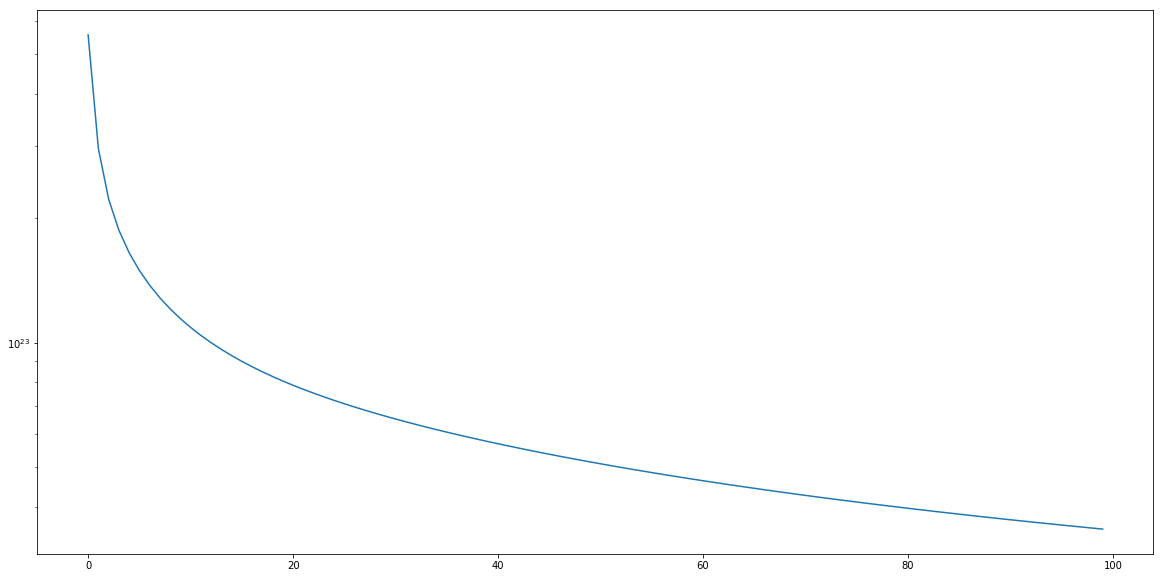

In [21]:
fig, ax = plt.subplots(figsize = (20,10))
plt.semilogy(S.Frob_norm_iter)

In [41]:
hv = 2. * vmax / N
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, N)
vx, vy, vz = np.meshgrid(vx_, vx_, vx_, indexing='ij')
v_nil = np.sqrt(1./3.) * (vx + vy + vz)
v_nil_tt = tt.tensor(v_nil)

v_nil_plus = np.zeros((N, N, N))

for i in np.ndindex(v_nil.shape):
    if v_nil[i] > 0:
        v_nil_plus[i] = v_nil[i]
    else:
        v_nil_plus[i] = 0.
v_nil_plus_tt = tt.tensor(v_nil_plus)

print v_nil_plus_tt.core.shape, N**3

 (28800,) 27000


In [44]:
vx_l = np.zeros((N, N, N))
vx_r = np.zeros((N, N, N))
    
for i in np.ndindex(vx.shape):
    if vx[i] > 0:
        vx_l[i] = vx[i]
    else:
        vx_l[i] = 0.
            
vx_r = vx - vx_l
            
vx_l = tt.tensor(vx_l)
vx_r = tt.tensor(vx_r)
print vx_l

This is a 3-dimensional tensor 
r(0)=1, n(0)=30 
r(1)=1, n(1)=30 
r(2)=1, n(2)=30 
r(3)=1 

